### Windfarms

Here are some examples of windfarms. The name of the files contain the ID of the windfarm. The ERA5 data was selected based on the location in this xls table

In [1]:
import pandas as pd
df = pd.read_excel("https://www.thewindpower.net/data/samples/Sample_World_Windfarms.xls", sheet_name="Windfarms", skiprows=[1])
df.pop("2nd name")
df.head()  # remove .head() to see the full table

,ID,Continent,ISO code,Country,State code,Area,City,Name,Latitude,Longitude,...,Number of turbines,Total power,Developer,Operator,Owner,Commissioning date,Status,Decommissioning date,Link,Update
0,27,Oceania,AU,Australia,QLD,Queensland,Ravenshoe,Windy Hill,-17.590006,145.531549,...,20,12000,Stanwell Corp,Stanwell Corp,Ratch Australia Corporation,2000/08,Production,NaN,Link,2022-10-25
1,13,Europe,BE,Belgium,#ND,Brabant wallon (Wallonie),Villers-la-Ville,Marbais,50.537381,4.514866,...,8,16000,Eneco,Electrastar SA,Eneco,2007,Production,NaN,Link,2022-10-20
2,12,Europe,BE,Belgium,#ND,Liège (Wallonie),Villers le Bouillet,Villers le Bouillet,50.580000,5.240000,...,6,9000,EDF renewables/Energie 2030,EDF renewables,EDF Luminus,2005/02,Production,NaN,Link,2022-05-20
3,16,Europe,BE,Belgium,#ND,Namur (Wallonie),Floreffe,Floreffe,50.422861,4.718278,...,1,2350,EDF Luminus,EDF Luminus,EDF Luminus,2010,Production,NaN,Link,2022-05-20
4,11,Europe,BE,Belgium,#ND,Namur (Wallonie),Walcourt,Tarcienne,50.302828,4.504480,...,6,9000,EDF renewables,EDF renewables,EDF Luminus,2005/11,Production,NaN,Link,2022-05-20


In [2]:
import xarray as xr
import glob
import os

# select the windfarm
wind_farm_id = 14
# modify the basepath accordingly
basepath = "/shared1/ICS/LOT1/windpower/"

files = glob.glob(os.path.join(basepath, "ID_{}_*.nc".format(wind_farm_id)))

assert len(files) == 1 # make sure there is only one file

ds = xr.open_dataset(files[0])

ds

<xarray.Dataset>
Dimensions:    (time: 140256)
Coordinates:
  * time       (time) datetime64[ns] 1990-01-01 ... 2005-12-31T23:00:00
    longitude  float32 ...
    latitude   float32 ...
Data variables:
    ws100      (time) float32 ...
Attributes:
    CDI:                 Climate Data Interface version 1.9.6 (http://mpimet....
    Conventions:         CF-1.6
    history:             Mon Mar 20 14:34:04 2023: cdo -b F32 chname,u100,ws1...
    CDO:                 Climate Data Operators version 1.9.6 (http://mpimet....
    bias_adj_procedure:  Delta method: https://www.nature.com/articles/s41597...
    reference dataset:   Global Wind Atlas 3.0, a free, web-based application...

Next, give some parameters for the turbine at this location. 

In [3]:
import numpy as np
import power_curves as pc

# power_conversion_function_csv = pc.power_curve_from_csv("https://www.thewindpower.net/data/samples/Sample_Power_curves.xls", "MM82", "Turbine Name")

power_conversion_function_parameters = [
    {"Pnom": 2000, "Drotor": 80},
    {"Pnom": 2000, "Drotor": 85},
    {"Pnom": 3000, "Drotor": 80},
]

labels = ["Pnom: {Pnom} kW, Drotor: {Drotor} m".format(**kwargs) for kwargs in power_conversion_function_parameters]

power_conversion_functions = [pc.power_curve_from_parameters(wind_speed_resolution=0.5, **kwargs) for kwargs in power_conversion_function_parameters]

ds.ws100
power_da_list = [power_conversion_function(ds.ws100) for power_conversion_function in power_conversion_functions]

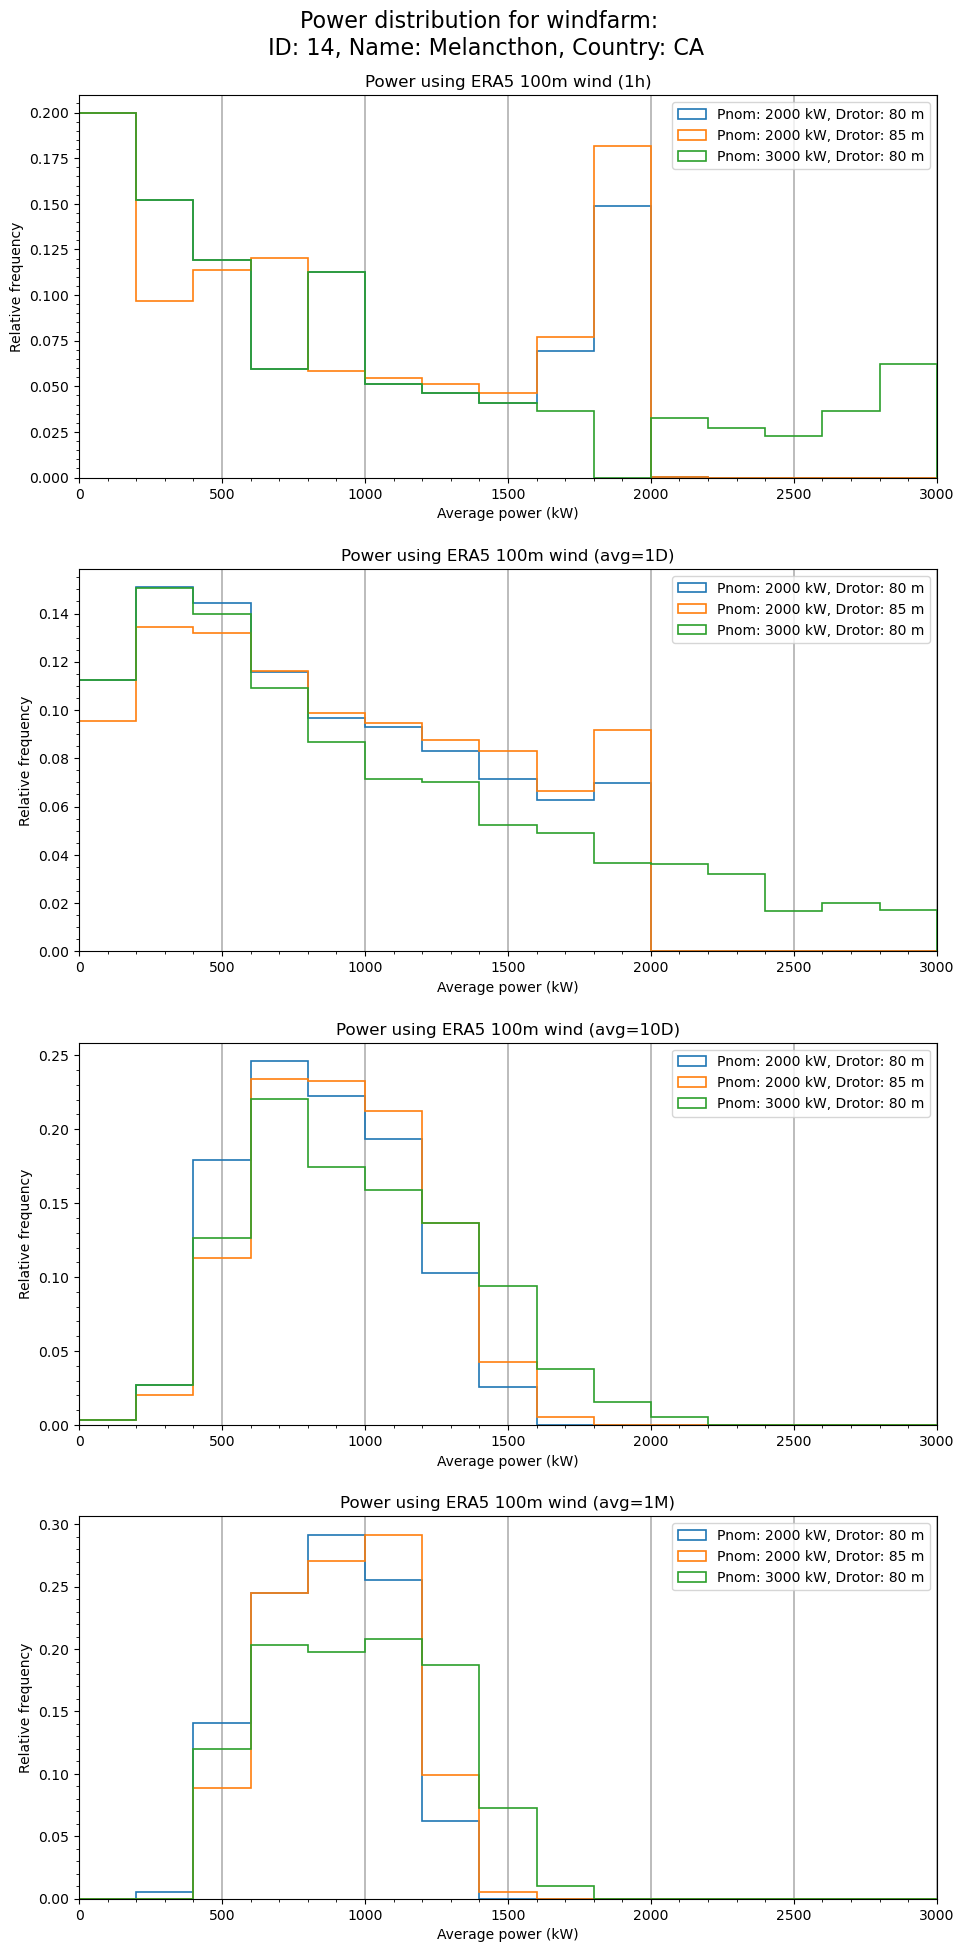

In [4]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import itertools

bins = np.arange(0, 3200, 200)

fig, axs = plt.subplots(4, 1, figsize=(10, 20))

resampling_frequencies = [None, "1D", "10D", "1M"]

for i, freq in enumerate(resampling_frequencies):

    colors = itertools.cycle(plt.get_cmap("tab10").colors)

    if freq is not None:
        power_da_resampled_list = [power_da.resample(time=freq).mean() for power_da in power_da_list]
    else:
        power_da_resampled_list = power_da_list

    for color, label, power_da_resampled in zip(colors, labels, power_da_resampled_list):
        weights = np.ones_like(power_da_resampled) / len(power_da_resampled)
        n, bins, patches = axs[i].hist(power_da_resampled, bins=bins, weights=weights,
                                       edgecolor=color, linewidth=1.2,
                                       density=False, facecolor="none",
                                       histtype="step", label=label)

    # Adjust the y-axis limits
    axs[i].set_ylim(0, axs[i].get_ylim()[1] / sum(n))

    # Adjust the x-axis limits
    axs[i].set_xlim(0, 3000)

    # Set the title
    if freq is None:
        axs[i].set_title('Power using ERA5 100m wind (1h)')
    else:
        axs[i].set_title(f'Power using ERA5 100m wind (avg={freq})')
    
    axs[i].set_xticks(np.arange(0, 3500, 500))
    axs[i].grid(axis="x", linestyle="-", linewidth=1.2)

    axs[i].set_axisbelow(True)

    # Set x and y labels
    axs[i].set_xlabel('Average power (kW)')
    axs[i].set_ylabel('Relative frequency')

    axs[i].xaxis.set_minor_locator(ticker.AutoMinorLocator())
    axs[i].yaxis.set_minor_locator(ticker.AutoMinorLocator())

    axs[i].legend(loc="upper right")

# set the title of the figure
fig.suptitle("Power distribution for windfarm: \n ID: {}, Name: {}, Country: {}".format(
    wind_farm_id, df[df["ID"] == wind_farm_id]["Name"].values[0], df[df["ID"] == wind_farm_id]["ISO code"].values[0]
), fontsize=16)

plt.tight_layout(pad = 2)
plt.show()